In [1]:
% pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


In [86]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.3.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [85]:
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation,metrics
from sklearn.grid_search import GridSearchCV

C:\Users\Ambar Gupta\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Ambar Gupta\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [91]:
train = pd.read_csv('train.csv')

In [92]:
train.head()

,TID,vendor_id,new_user,tolls_amount,tip_amount,mta_tax,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,surcharge,fare_amount
0,AIX000345001,DST000401,NO,0.0,1.4,0.5,2015-04-20 04:18:25,2015-04-20 04:24:20,1,-74.003939,40.742894,1,N,-73.993369,40.734247,CRD,0.5,8.4
1,AIX000345002,DST000401,NO,0.0,1.0,0.5,2015-04-19 18:16:07,2015-04-19 18:22:06,3,-73.973864,40.752194,1,N,-73.958701,40.772533,CRD,0.0,8.5
2,AIX000345003,DST000401,NO,0.0,0.0,0.5,2015-04-06 08:04:32,2015-04-06 08:10:05,2,-73.954406,40.764420,1,N,-73.970780,40.758350,CSH,0.0,7.0
3,AIX000345004,DST000532,NO,0.0,1.8,0.5,2015-04-10 09:48:00,2015-04-10 10:00:00,2,-73.962345,40.767215,1,NaN,-73.975512,40.756867,CRD,0.0,11.3
4,AIX000345005,DST000401,NO,0.0,0.0,0.5,2015-04-15 13:12:48,2015-04-15 13:26:30,1,-74.004657,40.707434,1,N,-73.999369,40.721517,CSH,0.0,10.0


In [93]:
train.describe()

C:\Users\Ambar Gupta\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,tolls_amount,tip_amount,mta_tax,passenger_count,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,surcharge,fare_amount
count,1.658099e+06,1.492903e+06,1.658099e+06,1.658099e+06,1.608290e+06,1.624998e+06,1.658099e+06,1.653112e+06,1.649937e+06,1.558926e+06,1.658099e+06
mean,2.770844e-01,1.554779e+00,4.980460e-01,1.722504e+00,-7.258480e+01,3.998628e+01,1.035918e+00,-7.258127e+01,3.998414e+01,3.177296e-01,1.531551e+01
std,1.890095e+00,2.356677e+00,3.194602e-02,1.384761e+00,1.004539e+01,5.528833e+00,4.683282e-01,1.005460e+01,5.538230e+00,3.623541e-01,1.272185e+01
min,-1.175000e+01,0.000000e+00,-5.000000e-01,0.000000e+00,-9.908311e+01,-1.355188e+01,0.000000e+00,-1.190126e+02,-1.355188e+01,-1.000000e+00,0.000000e+00
25%,0.000000e+00,NaN,5.000000e-01,1.000000e+00,NaN,NaN,1.000000e+00,NaN,NaN,NaN,8.300000e+00
50%,0.000000e+00,NaN,5.000000e-01,1.000000e+00,NaN,NaN,1.000000e+00,NaN,NaN,NaN,1.150000e+01
75%,0.000000e+00,NaN,5.000000e-01,2.000000e+00,NaN,NaN,1.000000e+00,NaN,NaN,NaN,1.700000e+01
max,1.450090e+03,2.312000e+02,5.000000e-01,9.000000e+00,7.945679e+01,6.798689e+01,2.100000e+02,0.000000e+00,6.343189e+01,2.050000e+01,1.502890e+03


In [94]:
def convert_datetime(X):
    X['pickup_datetime'] = X['pickup_datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    X['dropoff_datetime'] = X['dropoff_datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    return X

In [95]:
def cal(X):
    df = pd.DataFrame()
    df['diff'] = X['dropoff_datetime'] - X['pickup_datetime']
    df['diff'] = df['diff'].apply(lambda x:divmod(x.days * 86400 + x.seconds, 60))
    df['diff'] = df['diff'].apply(lambda x:abs(x[0]+(x[1]/60)))
    return df['diff']

In [96]:
train = convert_datetime(train)

In [8]:
train['total_jrny'] = cal(train)

In [88]:
train[train['total_jrny']<0]

,TID,vendor_id,new_user,tolls_amount,tip_amount,mta_tax,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,...,dropoff_latitude,surcharge,fare_amount,total_jrny,CRD,CSH,DIS,NOC,UNK,distance
109046,AIX000454047,0,0,0.0,0.000000,0.5,2015-02-22 06:49:57,2015-02-22 06:47:03,1,0.0,...,0.0,0.0,2.738613,-2.900000,1.0,0.0,0.0,0.0,0.0,0.0
294424,AIX000639425,0,0,0.0,1.554779,0.0,2015-01-28 15:49:04,2015-01-28 15:49:03,1,0.0,...,0.0,0.0,10.464225,-0.016667,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
train.isnull().sum()

TID                        0
vendor_id                  0
new_user                  19
tolls_amount               0
tip_amount            165196
mta_tax                    0
pickup_datetime            0
dropoff_datetime           0
passenger_count            0
pickup_longitude       49809
pickup_latitude        33101
rate_code                  0
store_and_fwd_flag    648122
dropoff_longitude       4987
dropoff_latitude        8162
payment_type               0
surcharge              99173
fare_amount                0
total_jrny                 0
dtype: int64

In [10]:
train.corr()[((train.corr() < -0.85) | (train.corr() > 0.85)) & (train.corr() != 1)]

,tolls_amount,tip_amount,mta_tax,passenger_count,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,surcharge,fare_amount,total_jrny
tolls_amount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tip_amount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mta_tax,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passenger_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pickup_longitude,NaN,NaN,NaN,NaN,NaN,-0.999818,NaN,0.902054,-0.901793,NaN,NaN,NaN
pickup_latitude,NaN,NaN,NaN,NaN,-0.999818,NaN,NaN,-0.902017,0.901948,NaN,NaN,NaN
rate_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dropoff_longitude,NaN,NaN,NaN,NaN,0.902054,-0.902017,NaN,NaN,-0.999824,NaN,NaN,NaN
dropoff_latitude,NaN,NaN,NaN,NaN,-0.901793,0.901948,NaN,-0.999824,NaN,NaN,NaN,NaN
surcharge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
train.columns

Index(['TID', 'vendor_id', 'new_user', 'tolls_amount', 'tip_amount', 'mta_tax',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'rate_code',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'surcharge', 'fare_amount', 'total_jrny'],
      dtype='object')

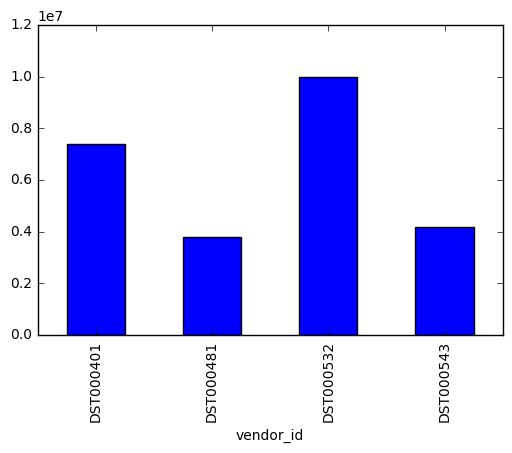

In [12]:
train.groupby('vendor_id')['fare_amount'].sum().plot.bar()

In [13]:
def convert_vendorid(s):
    if '401' in s:
        return 0
    else:
        return int(s[-1])

In [14]:
train['vendor_id'] = train['vendor_id'].apply(lambda x:convert_vendorid(x))

In [15]:
train['vendor_id'].value_counts()

2    648113
0    494087
3    268691
1    247208
Name: vendor_id, dtype: int64

In [16]:
train['new_user'] = train['new_user'].fillna('NO')

In [17]:
train['new_user'].isnull().sum()

0

In [18]:
train['new_user'] = pd.Series(np.where(train.new_user.values=='yes',1,0),train.index)

In [19]:
train.new_user.head()

0    0
1    0
2    0
3    0
4    0
Name: new_user, dtype: int32

In [20]:
train['tolls_amount'].describe()

count    1.658099e+06
mean     2.770844e-01
std      1.890095e+00
min     -1.175000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.450090e+03
Name: tolls_amount, dtype: float64

In [21]:
train['tip_amount'] = train['tip_amount'].fillna(train['tip_amount'].mean())

In [22]:
train['tip_amount'].isnull().sum()

0

In [23]:
train.columns

Index(['TID', 'vendor_id', 'new_user', 'tolls_amount', 'tip_amount', 'mta_tax',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'rate_code',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'surcharge', 'fare_amount', 'total_jrny'],
      dtype='object')

In [24]:
train['mta_tax'].value_counts()

 0.5    1651776
 0.0       6166
-0.5        157
Name: mta_tax, dtype: int64

In [25]:
train['passenger_count'].value_counts()

1    1157281
2     231883
5      99002
3      69928
6      65726
4      33956
0        315
7          5
9          2
8          1
Name: passenger_count, dtype: int64

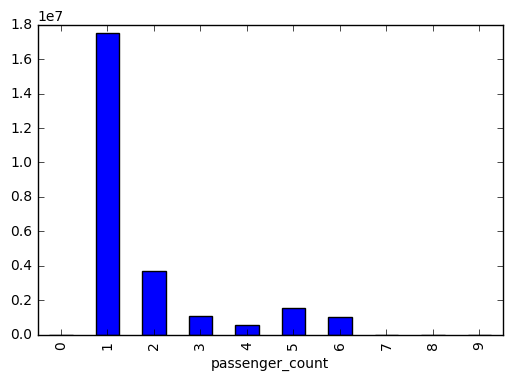

In [26]:
train.groupby('passenger_count')['fare_amount'].sum().plot.bar()

In [27]:
train.columns

Index(['TID', 'vendor_id', 'new_user', 'tolls_amount', 'tip_amount', 'mta_tax',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'rate_code',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'surcharge', 'fare_amount', 'total_jrny'],
      dtype='object')

In [28]:
train['rate_code'].describe()

count    1.658099e+06
mean     1.035918e+00
std      4.683282e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.100000e+02
Name: rate_code, dtype: float64

In [29]:
train['rate_code'].value_counts()

1      1618770
2        31211
5         4842
3         2623
4          568
0           49
6           18
99          16
210          2
Name: rate_code, dtype: int64

In [30]:
train['store_and_fwd_flag'].value_counts()

N    993926
Y     16051
Name: store_and_fwd_flag, dtype: int64

In [31]:
train.columns

Index(['TID', 'vendor_id', 'new_user', 'tolls_amount', 'tip_amount', 'mta_tax',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'rate_code',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'surcharge', 'fare_amount', 'total_jrny'],
      dtype='object')

In [32]:
df = train['payment_type']

In [33]:
df = pd.get_dummies(df)

In [34]:
train = train.drop('payment_type',axis=1)

In [35]:
train = pd.concat([train,df],axis=1)

In [36]:
train.columns

Index(['TID', 'vendor_id', 'new_user', 'tolls_amount', 'tip_amount', 'mta_tax',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'rate_code',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'surcharge', 'fare_amount', 'total_jrny', 'CRD', 'CSH', 'DIS', 'NOC',
       'UNK'],
      dtype='object')

In [37]:
train['surcharge'] = train['surcharge'].fillna(train['surcharge'].mean())

In [38]:
train['fare_amount'].describe()

count    1.658099e+06
mean     1.531551e+01
std      1.272185e+01
min      0.000000e+00
25%      8.300000e+00
50%      1.150000e+01
75%      1.700000e+01
max      1.502890e+03
Name: fare_amount, dtype: float64

In [39]:
train['fare_amount'] = np.sqrt(train['fare_amount'])

# feature Engineering

C:\Users\Ambar Gupta\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


{'boxes': [<matplotlib.lines.Line2D at 0x260804b1278>],
 'caps': [<matplotlib.lines.Line2D at 0x260804babe0>,
 'fliers': [<matplotlib.lines.Line2D at 0x260804bfdd8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x260804bf5c0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x260804aaf60>,
  <matplotlib.lines.Line2D at 0x260804b1cf8>]}

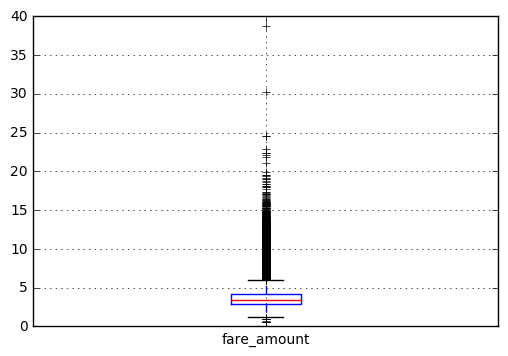

In [40]:
train.boxplot(column='fare_amount')

In [41]:
from math import cos, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a))

In [42]:
train.columns

Index(['TID', 'vendor_id', 'new_user', 'tolls_amount', 'tip_amount', 'mta_tax',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'rate_code',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'surcharge', 'fare_amount', 'total_jrny', 'CRD', 'CSH', 'DIS', 'NOC',
       'UNK'],
      dtype='object')

In [43]:
train.isnull().sum()

TID                        0
vendor_id                  0
new_user                   0
tolls_amount               0
tip_amount                 0
mta_tax                    0
pickup_datetime            0
dropoff_datetime           0
passenger_count            0
pickup_longitude       49809
pickup_latitude        33101
rate_code                  0
store_and_fwd_flag    648122
dropoff_longitude       4987
dropoff_latitude        8162
surcharge                  0
fare_amount                0
total_jrny                 0
CRD                        0
CSH                        0
DIS                        0
NOC                        0
UNK                        0
dtype: int64

In [44]:
train= train.drop('store_and_fwd_flag',axis=1)

In [45]:
train.isnull().sum()

TID                      0
vendor_id                0
new_user                 0
tolls_amount             0
tip_amount               0
mta_tax                  0
pickup_datetime          0
dropoff_datetime         0
passenger_count          0
pickup_longitude     49809
pickup_latitude      33101
rate_code                0
dropoff_longitude     4987
dropoff_latitude      8162
surcharge                0
fare_amount              0
total_jrny               0
CRD                      0
CSH                      0
DIS                      0
NOC                      0
UNK                      0
dtype: int64

In [46]:
train = train.dropna(how='any')

In [47]:
len(train)

1563731

In [48]:
train['distance'] = train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

In [49]:
train['distance'].head()

0    1.310554
1    2.597243
2    1.535378
3    1.598049
4    1.628146
Name: distance, dtype: float64

In [50]:
train.columns

Index(['TID', 'vendor_id', 'new_user', 'tolls_amount', 'tip_amount', 'mta_tax',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'rate_code', 'dropoff_longitude',
       'dropoff_latitude', 'surcharge', 'fare_amount', 'total_jrny', 'CRD',
       'CSH', 'DIS', 'NOC', 'UNK', 'distance'],
      dtype='object')

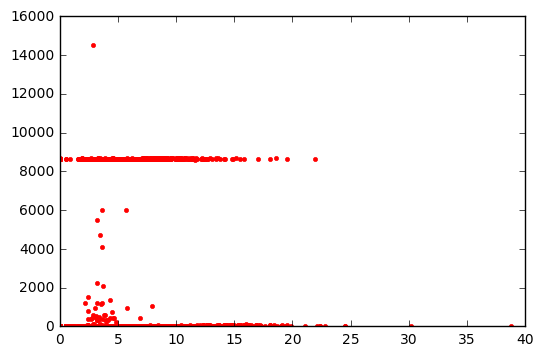

In [51]:
plt.plot(train['fare_amount'],train['distance'],'r.')

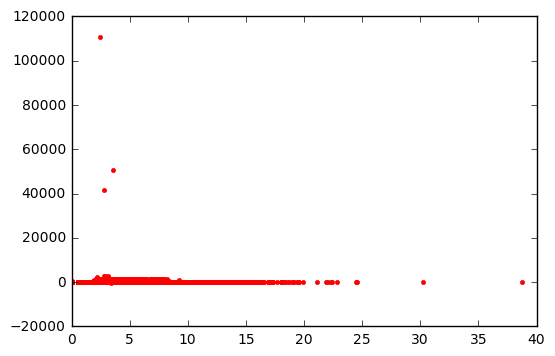

In [52]:
plt.plot(train['fare_amount'],train['total_jrny'],'r.')

In [53]:
train = train[train['total_jrny']<40]

In [54]:
train = train[train['fare_amount']<25]

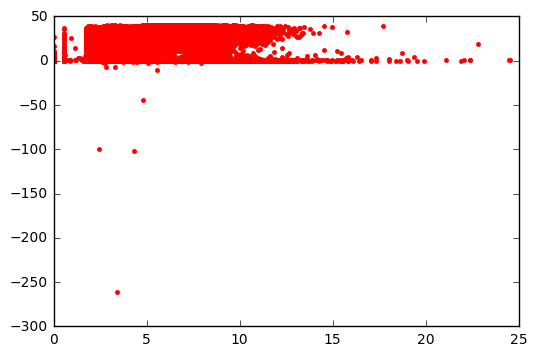

In [55]:
plt.plot(train['fare_amount'],train['total_jrny'],'r.')

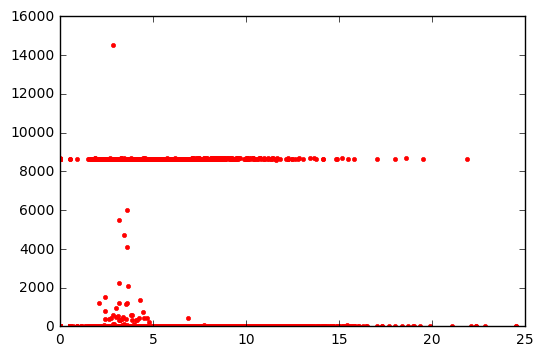

In [56]:
plt.plot(train['fare_amount'],train['distance'],'r.')

In [57]:
train = train[train['distance']<100]

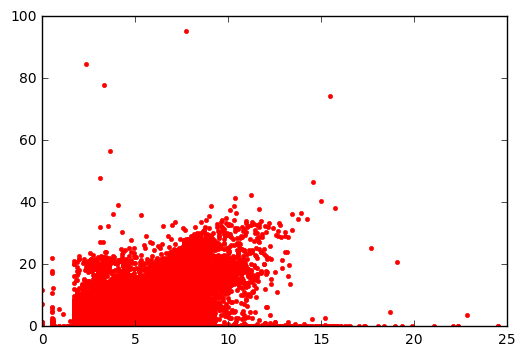

In [58]:
plt.plot(train['fare_amount'],train['distance'],'r.')

{'boxes': [<matplotlib.lines.Line2D at 0x260814bc400>],
 'caps': [<matplotlib.lines.Line2D at 0x260814c1d68>,
 'fliers': [<matplotlib.lines.Line2D at 0x260814c8f60>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x260814c8748>],
 'whiskers': [<matplotlib.lines.Line2D at 0x260814bcdd8>,
  <matplotlib.lines.Line2D at 0x260814bcf60>]}

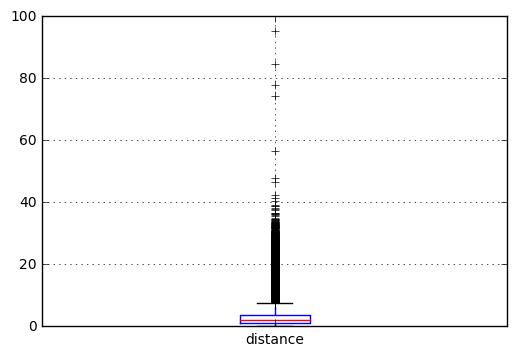

In [59]:
train.boxplot(column='distance',return_type='dict')

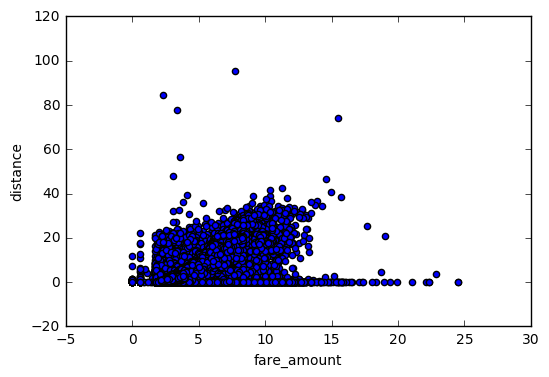

In [60]:
train.plot.scatter('fare_amount','distance')

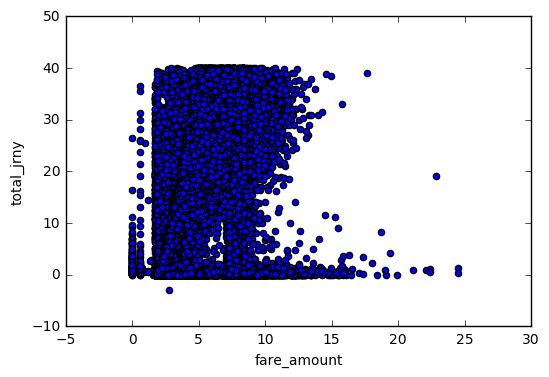

In [61]:
train.plot.scatter('fare_amount','total_jrny')

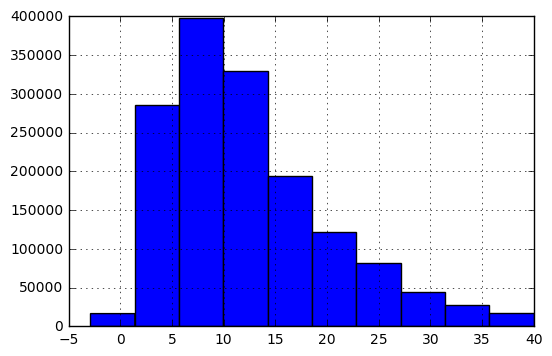

In [62]:
train['total_jrny'].hist()

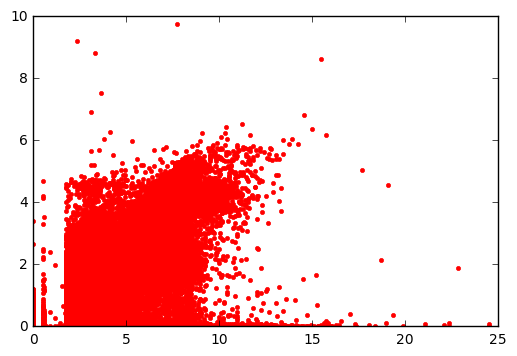

In [63]:
plt.plot(train['fare_amount'],np.sqrt(train['distance']),'r.')

In [1]:
features = ['total_jrny','distance']

In [65]:
X = train[features]
y = train['fare_amount']

In [66]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [67]:
lin_model = LinearRegression(normalize=True)

In [68]:
lin_model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [69]:
test = pd.read_csv('test.csv')

In [70]:
test.isnull().sum()

TID                       0
vendor_id                 0
new_user                 22
tolls_amount              0
tip_amount            51310
mta_tax                   0
pickup_datetime           0
dropoff_datetime          0
passenger_count           0
pickup_longitude      15339
pickup_latitude       10095
rate_code                 0
store_and_fwd_flag        0
dropoff_longitude      1584
dropoff_latitude       2563
payment_type              0
surcharge             30727
dtype: int64

In [71]:
def distance1(row):
    lat1 = row['pickup_longitude']
    lon1 = row['pickup_latitude']
    lat2 = row['dropoff_latitude']
    lon2 = row['dropoff_longitude']
    if(np.isnan(lat1) or np.isnan(lon1) or np.isnan(lat2) or np.isnan(lon2)):
        return 0
    else:
        p = 0.017453292519943295     #Pi/180
        a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
        return 12742 * asin(sqrt(a))

In [72]:
def update_test(test):
    print('updating datetime')
    test = convert_datetime(test)
    test['total_jrny'] = cal(test)
    print('done')      
    print('updating vendorid')
    test['vendor_id'] = test['vendor_id'].apply(lambda x:convert_vendorid(x))
    print('done')      
    print('updating new_user')
    test['new_user'] = test['new_user'].fillna('NO')
    test['new_user'] = pd.Series(np.where(test.new_user.values=='yes',1,0),test.index)
    print('done')      
    print('updating tip amount')
    test['tip_amount'] = test['tip_amount'].fillna(test['tip_amount'].mean())
    print('done')      
    print('updating payment type')
    df = test['payment_type']
    df = pd.get_dummies(df)      
    test = test.drop('payment_type',axis=1)
    test = pd.concat([test,df],axis=1)
    print('done')      
    print('updating surcharge')      
    test['surcharge'] = test['surcharge'].fillna(test['surcharge'].mean())    
    print('done')
    print('creating distance....')      
    test['distance'] = test.apply(lambda row:distance1(row),axis=1)
    print('done')
    print('process complete')
    return test

In [73]:
test = update_test(test)

updating datetime
done
updating vendorid
done
updating new_user
done
updating tip amount
done
updating payment type
done
updating surcharge
done
creating distance....
done
process complete


In [74]:
test['distance'].head()

0    15087.346170
1    15077.446616
2    15082.444034
3    15073.642922
4    15080.729691
Name: distance, dtype: float64

In [75]:
test.isnull().sum()

TID                       0
vendor_id                 0
new_user                  0
tolls_amount              0
tip_amount                0
mta_tax                   0
pickup_datetime           0
dropoff_datetime          0
passenger_count           0
pickup_longitude      15339
pickup_latitude       10095
rate_code                 0
store_and_fwd_flag        0
dropoff_longitude      1584
dropoff_latitude       2563
surcharge                 0
total_jrny                0
CRD                       0
CSH                       0
DIS                       0
NOC                       0
UNK                       0
distance                  0
dtype: int64

In [76]:
mean = test['distance'].mean()

In [77]:
mean

14017.710137522063

In [78]:
def update_distance(x):
    if x==0:
        return mean
    else:
        return x

In [79]:
test['distance'] = test['distance'].apply(lambda x:update_distance(x))

In [80]:
test.isnull().sum()

TID                       0
vendor_id                 0
new_user                  0
tolls_amount              0
tip_amount                0
mta_tax                   0
pickup_datetime           0
dropoff_datetime          0
passenger_count           0
pickup_longitude      15339
pickup_latitude       10095
rate_code                 0
store_and_fwd_flag        0
dropoff_longitude      1584
dropoff_latitude       2563
surcharge                 0
total_jrny                0
CRD                       0
CSH                       0
DIS                       0
NOC                       0
UNK                       0
distance                  0
dtype: int64

In [81]:
X_test = test[features]

In [82]:
pred = lin_model.predict(X_test)

In [83]:
pred = np.square(pred)

In [84]:
# create submission file
submission = pd.DataFrame(data=[], columns=['TID', 'fare_amount'])
submission.TID = test.TID; submission.fare_amount = pred
submission.to_csv('submission.csv', index=False)
submission.head()

,TID,fare_amount
0,AJX000119871,3.721538e+06
1,AJX000119872,3.718330e+06
2,AJX000119873,3.721624e+06
3,AJX000119874,3.721003e+06
4,AJX000119875,3.722257e+06
